In [1]:
import torch
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader

from aivolved.dataset import get_img_dataset_normalisation, MaskedImageDataset

DATA_PATH = "data/soap/soap-80-20-20/"

train_dataset = MaskedImageDataset(DATA_PATH + "train/non_defects/",
                                   transform=transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToImage(),
                                       transforms.ToDtype(torch.float32, scale=True),
                                   ]), select_channel=2)
mean, stdev = get_img_dataset_normalisation(train_dataset)

Training Images: 670
Batches: 6


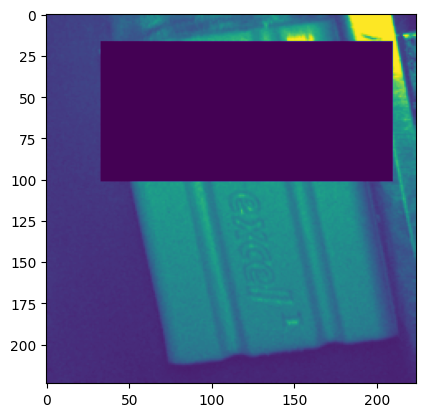

In [2]:
import matplotlib.pyplot as plt
from math import ceil

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([mean], [stdev])
])

BATCH_SIZE = 128
print("Training Images:", len(train_dataset))
print("Batches:", ceil(len(train_dataset) / BATCH_SIZE))

train_dataset = MaskedImageDataset(DATA_PATH + "train/non_defects", transform=train_transforms, select_channel=2, fourier_domain=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, persistent_workers=True)

valid_dataset = MaskedImageDataset(DATA_PATH + "val/non_defects", transform=train_transforms, select_channel=2, fourier_domain=True)
valid_dataloader = DataLoader(train_dataset, batch_size=len(valid_dataset), num_workers=1, pin_memory=True, persistent_workers=True)

img = train_dataset[0][0]
plt.imshow(img[0])

In [13]:
from aivolved.device import get_device
from aivolved.unet import unet

import torch.nn as nn
import lightning as pl


class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        self.model = unet.Unet(backbone_name="resnet18", classes=1, pretrained=False)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x.unsqueeze_(-3)
        x = x.repeat(1, 3, 1, 1)
        x = self.model(x)
        return x.squeeze()
    
    def calculate_loss(self, y_hat, y):
        return self.criterion(y_hat, y)

    def _step(self, batch, _, step: str):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.calculate_loss(y_hat, y)
        self.log(f"{step}_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, batch_idx, "valid")

    def test_step(self, batch, batch_idx):
        self._step(batch, batch_idx, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam([{"params": self.model.get_pretrained_parameters(), "lr": 4e-1},
                                      {'params': self.model.get_random_initialized_parameters()}],
                                     lr=4e-1)
        return optimizer


class FourierAutoencoder(Autoencoder):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        self.model = unet.Unet(backbone_name="resnet18", classes=2, pretrained=False)
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        x = self.model(x)
        return x.squeeze()

    def calculate_loss(self, y_hat, y):
        return self.criterion(y_hat, y[:, :2])


Autoencoder()

upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


Autoencoder(
  (model): Unet(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm

In [14]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [15]:
wandb.finish()

model = FourierAutoencoder()
wandb_logger = WandbLogger(project="soap-defect-detection")

upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16
upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [16]:
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=6, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | Unet    | 16.1 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
16.1 M    Trainable params
0         Non-trainable params
16.1 M    Total params
64.253    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


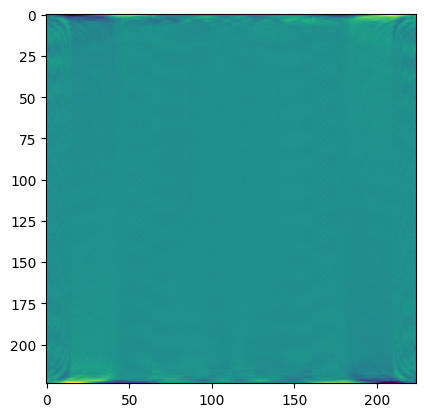

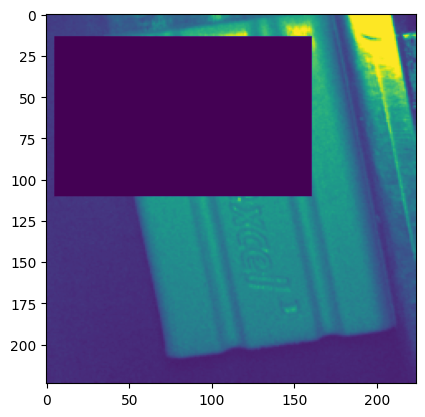

In [54]:
import numpy as np

model = model.eval()

data = torch.Tensor(train_dataset[20][0]).unsqueeze(0)
out = model(data).detach().numpy()
out = np.fft.ifft(out[0] + out[1] * 1j).real

plt.imshow(out)
plt.figure()
plt.imshow(data[0][0])

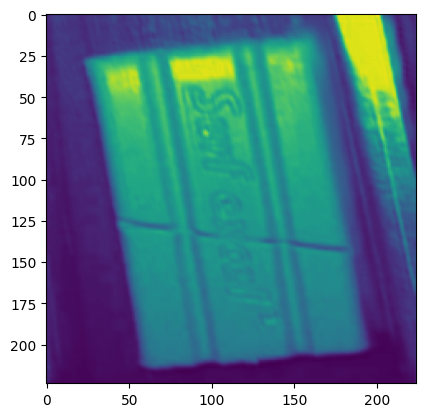

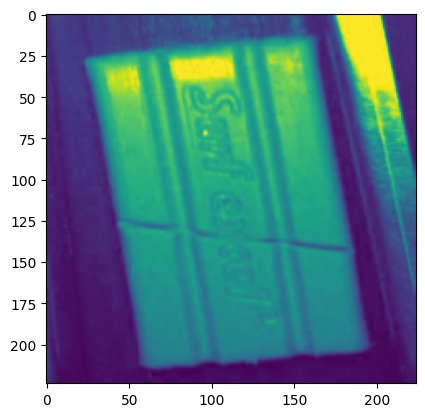

In [91]:
test_dataset = MaskedImageDataset(DATA_PATH + "train/defects", transform=train_transforms, select_channel=2)

data = test_dataset[20][1]
out = model(data).detach().numpy()
plt.imshow(out)
plt.figure()
plt.imshow(data[0])